In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import DBSCAN, HDBSCAN
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import kendalltau, norm
import cvxpy as cp
import calendar
from datetime import date
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
folder_path = '/content/drive/My Drive/fednlp/ai/'
prices_info = pd.read_csv(f'{folder_path}prices_info.csv.gz', compression='gzip')
ratios_info = pd.read_csv(f'{folder_path}ratios.csv.gz', compression='gzip')
sector_info = pd.read_csv(f'{folder_path}sector_info.csv.gz', compression='gzip')
sp500 = pd.read_pickle(f'{folder_path}sp500.pkl')
relations = pd.read_csv(f'{folder_path}lorlxamlga34g2og.csv')
rels2 = pd.read_feather(f'{folder_path}econ_link_filt2.feather')

ratios = ratios_info.drop(columns=['gvkey','cusip','adate','qdate'])

In [3]:
factor_etf_lst = ["SPY", "SIZE", "MTUM", "VLUE", "QUAL"]
etf_data = prices_info[prices_info['SYM_ROOT'].isin(factor_etf_lst)]

In [4]:
etf_data['DATE'] = pd.to_datetime(etf_data['DATE'])
etf_data = etf_data.sort_values(['symbol', 'DATE'])
etf_data['RET'] = etf_data.groupby('symbol')['mid_4pm'].pct_change()

/tmp/ipython-input-2430790147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_data['DATE'] = pd.to_datetime(etf_data['DATE'])
/tmp/ipython-input-2430790147.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  etf_data['RET'] = etf_data.groupby('symbol')['mid_4pm'].pct_change()


In [5]:
etf_data2 = etf_data[['DATE','symbol','RET']].copy()

In [6]:
# 1. Prepare Data
# Ensure dates are datetime objects
sp500['start_'] = pd.to_datetime(sp500['start'])
sp500['end_'] = pd.to_datetime(sp500['ending'])

# 2. Consolidate unique validity intervals for all tickers
# A ticker can be a source or a target; we need its validity regardless of position
sources = sp500[['ticker', 'start_', 'end_']]
# targets = sp500[['target_ticker', 'start_', 'end_']].rename(columns={'target_ticker': 'ticker'})

# Combine and drop duplicates to get unique intervals per ticker
all_intervals = sources.drop_duplicates().copy()

# 3. Define the Time Range
# Find the earliest and latest dates to generate the list of months to check
min_date = all_intervals['start_'].min()
max_date = all_intervals['end_'].max()

# Generate a range of Month Start dates
month_starts = pd.date_range(start=min_date, end=max_date, freq='MS')

# 4. Build the Universe Dictionary
universe_dict2 = {}

for date in month_starts:
    # Define the full month window
    m_start = date
    m_end = date + pd.tseries.offsets.MonthEnd(0) # Gets the last day of this month

    # Filter tickers where the interval strictly covers the entire month
    # Logic: Interval Start <= Month Start  AND  Interval End >= Month End
    valid_mask = (all_intervals['start_'] <= m_start) & (all_intervals['end_'] >= m_end)

    # Get unique tickers for this specific month
    active_tickers = all_intervals.loc[valid_mask, 'ticker'].unique()

    # Store in dictionary if tickers exist for this month
    if len(active_tickers) > 0:
        universe_dict2[(date.year, date.month)] = active_tickers.tolist()

# Example usage:
# print(universe_dict[(2023, 1)]) # Returns list of tickers active for all of Jan 2023

In [7]:
# 1. Prepare Data
# Ensure dates are datetime objects
rels2['start_'] = pd.to_datetime(rels2['start_'])
rels2['end_'] = pd.to_datetime(rels2['end_'])

# 2. Consolidate unique validity intervals for all tickers
# A ticker can be a source or a target; we need its validity regardless of position
sources = rels2[['source_ticker', 'start_', 'end_']].rename(columns={'source_ticker': 'ticker'})
targets = rels2[['target_ticker', 'start_', 'end_']].rename(columns={'target_ticker': 'ticker'})

# Combine and drop duplicates to get unique intervals per ticker
all_intervals = pd.concat([sources, targets], ignore_index=True).drop_duplicates()

# 3. Define the Time Range
# Find the earliest and latest dates to generate the list of months to check
min_date = all_intervals['start_'].min()
max_date = all_intervals['end_'].max()

# Generate a range of Month Start dates
month_starts = pd.date_range(start=min_date, end=max_date, freq='MS')

# 4. Build the Universe Dictionary
universe_dict = {}

for date in month_starts:
    # Define the full month window
    m_start = date
    m_end = date + pd.tseries.offsets.MonthEnd(0) # Gets the last day of this month

    # Filter tickers where the interval strictly covers the entire month
    # Logic: Interval Start <= Month Start  AND  Interval End >= Month End
    valid_mask = (all_intervals['start_'] <= m_start) & (all_intervals['end_'] >= m_end)

    # Get unique tickers for this specific month
    active_tickers = all_intervals.loc[valid_mask, 'ticker'].unique()

    # Store in dictionary if tickers exist for this month
    if len(active_tickers) > 0:
        universe_dict[(date.year, date.month)] = active_tickers.tolist()

# Example usage:
# print(universe_dict[(2023, 1)]) # Returns list of tickers active for all of Jan 2023

In [8]:
universe_dict3 = {}
for k in universe_dict.keys():
  try:
    universe_dict3[k] = list(set(universe_dict2[k]).intersection(set(universe_dict[k])))
  except:
    print(f"Key {k} not found")

Key (2025, 1) not found
Key (2025, 2) not found
Key (2025, 3) not found
Key (2025, 4) not found
Key (2025, 5) not found
Key (2025, 6) not found
Key (2025, 7) not found
Key (2025, 8) not found
Key (2025, 9) not found
Key (2025, 10) not found
Key (2025, 11) not found
Key (2025, 12) not found


In [9]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# 1. Setup Time Range
# We start from 2002 to ensure we have data for the 1-year lookback for Jan 2003
start_date = '2013-01-01'
end_date = '2024-12-31'

# 2. Generate Business Days (Handling Holidays)
# USFederalHolidayCalendar handles standard holidays (New Years, Christmas, etc.)
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
dr = pd.date_range(start=start_date, end=end_date, freq=us_bd)

# Create a temporary dataframe of all trading days
daily_df = pd.DataFrame({'date': dr})
daily_df['YEAR'] = daily_df['date'].dt.year
daily_df['MONTH'] = daily_df['date'].dt.month

# 3. Aggregate to Monthly Level to find Start/End dates
monthly_df = daily_df.groupby(['YEAR', 'MONTH'])['date'].agg(
    TRADING_START_DATE='min',
    TRADING_END_DATE='max'
).reset_index()

# Sort to ensure shifting works correctly
monthly_df = monthly_df.sort_values(['YEAR', 'MONTH'])

# 4. Calculate Offset Dates (Lookbacks and Previous Months)

# Previous Month Start/End (Shift 1 month back)
monthly_df['PREV_MONTH_START_DATE'] = monthly_df['TRADING_START_DATE'].shift(1)
monthly_df['PREV_MONTH_END_DATE'] = monthly_df['TRADING_END_DATE'].shift(1)

# Lookback Start: The start date of the month 1 year ago (Shift 12 months back)
monthly_df['LOOKBACK_START_DATE'] = monthly_df['TRADING_START_DATE'].shift(12)

# Lookback End: The end date of the previous month (Same as PREV_MONTH_END_DATE)
# In your example: Jan 2015 lookback ends Dec 31, 2014.
monthly_df['LOOKBACK_END_DATE'] = monthly_df['PREV_MONTH_END_DATE']

# 5. Filter for the requested period (2003 - 2024)
# We generated 2002 just for the calculations, now we drop it.
final_df = monthly_df[(monthly_df['YEAR'] >= 2003) & (monthly_df['YEAR'] <= 2024)].copy()

# 6. Formatting to match your schema
# Cast types
final_df['YEAR'] = final_df['YEAR'].astype('int32')
final_df['MONTH'] = final_df['MONTH'].astype('int8')

# Reorder columns
cols = [
    'YEAR', 'MONTH',
    'TRADING_START_DATE', 'TRADING_END_DATE',
    'LOOKBACK_START_DATE', 'LOOKBACK_END_DATE',
    'PREV_MONTH_START_DATE', 'PREV_MONTH_END_DATE'
]
final_df = final_df[cols]

# Reset index for clean output
trading_window = final_df.reset_index(drop=True)

# Display sample to verify against your example
print(trading_window.head())

   YEAR  MONTH TRADING_START_DATE TRADING_END_DATE LOOKBACK_START_DATE  \
0  2013      1         2013-01-02       2013-01-31                 NaT   
1  2013      2         2013-02-01       2013-02-28                 NaT   
2  2013      3         2013-03-01       2013-03-29                 NaT   
3  2013      4         2013-04-01       2013-04-30                 NaT   
4  2013      5         2013-05-01       2013-05-31                 NaT   

  LOOKBACK_END_DATE PREV_MONTH_START_DATE PREV_MONTH_END_DATE  
0               NaT                   NaT                 NaT  
1        2013-01-31            2013-01-02          2013-01-31  
2        2013-02-28            2013-02-01          2013-02-28  
3        2013-03-29            2013-03-01          2013-03-29  
4        2013-04-30            2013-04-01          2013-04-30  


In [10]:
rets = sp500[['ticker','date','dlyretx']].copy()

In [11]:
rets.columns = ['TICKER','DATETIME','RET']

In [12]:
import networkx as nx
from sklearn.cluster import SpectralClustering
from pandas.tseries.offsets import MonthEnd

In [13]:
# 1. Prepare Data
rels2['start_'] = pd.to_datetime(rels2['start_'])
rels2['end_'] = pd.to_datetime(rels2['end_'])
rels2['Val'] = pd.to_numeric(rels2['Val'], errors='coerce').fillna(0)

# Create the target date range
dates = pd.date_range(start='2013-01-01', end='2024-12-31', freq='MS')

results_list = []

for date in dates:
    yr, mo = date.year, date.month

    # A. Get Valid Universe
    valid_universe = universe_dict3.get((yr, mo))
    if not valid_universe:
        continue

    valid_universe_set = set(valid_universe)

    # B. Define Month Boundaries
    m_start = date
    m_end = date + MonthEnd(0)

    # C. Filter Edges
    mask = (
        (rels2['start_'] <= m_start) &
        (rels2['end_'] >= m_end) &
        (rels2['source_ticker'].isin(valid_universe_set)) &
        (rels2['target_ticker'].isin(valid_universe_set))
    )

    current_edges = rels2.loc[mask, ['source_ticker', 'target_ticker', 'Val']]

    # D. Build Graph
    G = nx.from_pandas_edgelist(
        current_edges,
        source='source_ticker',
        target='target_ticker',
        edge_attr='Val'
    )

    # Add all universe nodes (essential for full coverage)
    G.add_nodes_from(valid_universe)

    nodes_list = list(G.nodes())
    if len(nodes_list) < 10:
        continue

    # E. Create Adjacency Matrix (Sparse)
    # FIX 1: Force 'csr' format, which has .indices and .indptr attributes
    adj_matrix = nx.to_scipy_sparse_array(G, nodelist=nodes_list, weight='Val', format='csr')

    # FIX 2: Manually cast indices to int32 to satisfy scikit-learn requirements
    adj_matrix.indices = adj_matrix.indices.astype(np.int32)
    adj_matrix.indptr = adj_matrix.indptr.astype(np.int32)

    # F. Perform Spectral Clustering
    # We increase n_init to help with the "not fully connected" warning stability
    sc = SpectralClustering(
        n_clusters=10,
        affinity='precomputed',
        assign_labels='discretize',
        random_state=42,
        eigen_solver='arpack',
        n_init=10
    )

    try:
        labels = sc.fit_predict(adj_matrix)
    except Exception:
        # Fallback if ARPACK fails on disconnected graphs (common in supply chains)
        # 'lobpcg' is often more robust for disconnected components
        sc.eigen_solver = 'lobpcg'
        labels = sc.fit_predict(adj_matrix)

    # G. Store Results
    month_result = pd.DataFrame({
        'TICKER': nodes_list,
        'cluster_id': labels
    })
    month_result['YEAR'] = yr
    month_result['MONTH'] = mo

    results_list.append(month_result)

# 3. Concatenate Final Output
if results_list:
    final_clusters = pd.concat(results_list, ignore_index=True)
    final_clusters = final_clusters[['YEAR', 'MONTH', 'TICKER', 'cluster_id']]
else:
    final_clusters = pd.DataFrame(columns=['YEAR', 'MONTH', 'TICKER', 'cluster_id'])

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ma

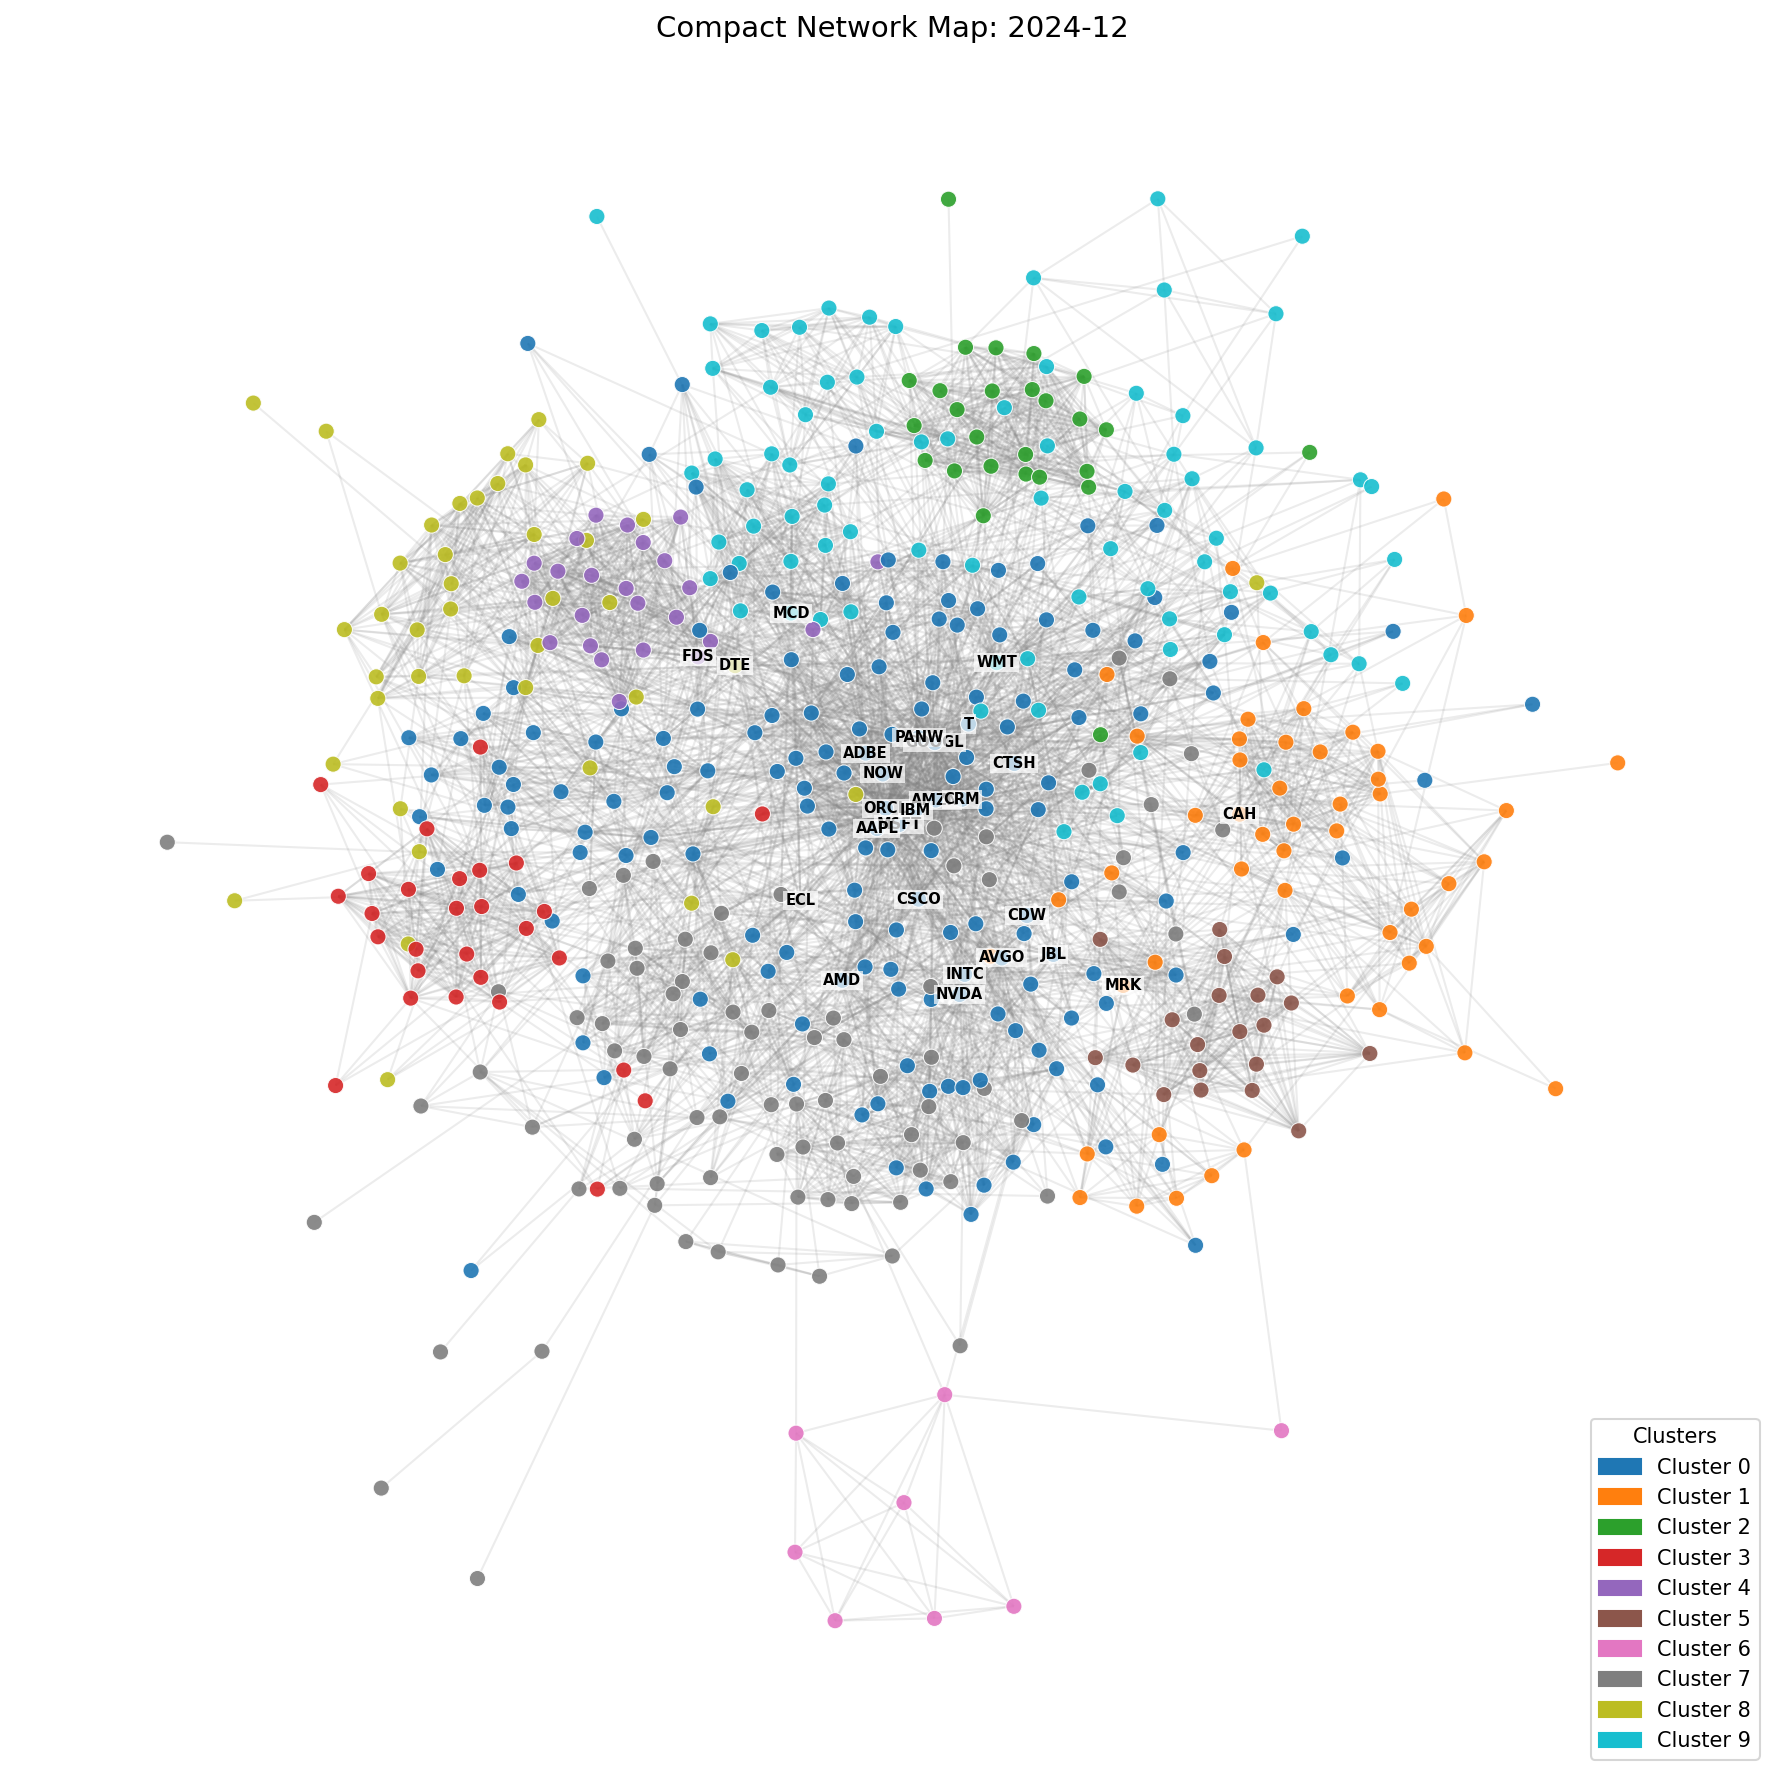

In [51]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ==========================================
# 1. SETUP DATA (DEC 2024)
# ==========================================
TARGET_YEAR = 2024
TARGET_MONTH = 12

node_data = final_clusters[
    (final_clusters['YEAR'] == TARGET_YEAR) &
    (final_clusters['MONTH'] == TARGET_MONTH)
].copy()

m_start = pd.Timestamp(f"{TARGET_YEAR}-{TARGET_MONTH}-01")
m_end = m_start + pd.tseries.offsets.MonthEnd(0)

edge_mask = (
    (rels2['start_'] <= m_start) &
    (rels2['end_'] >= m_end) &
    (rels2['source_ticker'].isin(node_data['TICKER'])) &
    (rels2['target_ticker'].isin(node_data['TICKER']))
)
edge_data = rels2.loc[edge_mask, ['source_ticker', 'target_ticker', 'Val']]

# ==========================================
# 2. BUILD GRAPH
# ==========================================
G = nx.Graph()
for _, row in node_data.iterrows():
    G.add_node(row['TICKER'], cluster=row['cluster_id'])

for _, row in edge_data.iterrows():
    G.add_edge(row['source_ticker'], row['target_ticker'], weight=row['Val'])

# Remove isolated nodes to prevent "flying away" artifacts
# This is the #1 cause of charts looking too spread out
G.remove_nodes_from(list(nx.isolates(G)))

# ==========================================
# 3. COMPACT LAYOUT CALCULATION
# ==========================================
plt.figure(figsize=(12, 12), dpi=150)

# OPTION A: Kamada-Kawai (Best for compact, circular "blob" shapes)
# It forces the graph into a unit circle area, ensuring nothing is "too far"
pos = nx.kamada_kawai_layout(G)

# OPTION B: Spring Layout (Alternative if Kamada is too slow)
# k=0.05 is VERY tight (default is usually ~0.3).
# iterations=100 gives it time to settle.
# pos = nx.spring_layout(G, k=0.05, iterations=100, seed=42)

# ==========================================
# 4. DRAWING
# ==========================================
clusters = [data['cluster'] for _, data in G.nodes(data=True)]
cmap = plt.get_cmap('tab10', 10)

# Draw Edges (Thinner and transparent for a dense look)
nx.draw_networkx_edges(
    G, pos,
    alpha=0.15,
    edge_color='grey'
)

# Draw Nodes
nx.draw_networkx_nodes(
    G, pos,
    node_color=clusters,
    cmap=cmap,
    node_size=60,
    alpha=0.9,
    linewidths=0.5,
    edgecolors='white' # White border makes overlapped nodes distinct
)

# Draw Labels (Only central/high-degree nodes)
degrees = dict(G.degree())
# Dynamic threshold: Label top 5% of nodes
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
top_n = int(len(G) * 0.05)
label_nodes = {n: n for n, d in sorted_nodes[:top_n]}

nx.draw_networkx_labels(
    G, pos,
    labels=label_nodes,
    font_size=7,
    font_color='black',
    font_weight='bold',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
)

# ==========================================
# 5. FINAL TOUCHES
# ==========================================
legend_patches = [mpatches.Patch(color=cmap(i), label=f'Cluster {i}') for i in range(10)]
plt.legend(handles=legend_patches, loc='lower right', title="Clusters")

plt.title(f"Compact Network Map: {TARGET_YEAR}-{TARGET_MONTH}", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
etf_data2 = etf_data2[['symbol','DATE','RET']]
etf_data2.columns = ['TICKER', 'DATETIME', 'RET']
etf_data2['DATETIME'] = pd.to_datetime(etf_data2['DATETIME'])
etf_data2['YEAR'] = etf_data2['DATETIME'].dt.year
etf_data2['MONTH'] = etf_data2['DATETIME'].dt.month
etf_data2['gsector'] = 10
etf_data2.dropna(inplace=True)

In [15]:
rets['DATETIME'] = pd.to_datetime(rets['DATETIME'])

# 2. Extract Year and Month from rets to match keys in final_clusters
rets['YEAR'] = rets['DATETIME'].dt.year
rets['MONTH'] = rets['DATETIME'].dt.month

# 3. Merge with the clusters dataframe
# We use a left join to keep all return data, filling NaN for tickers without a cluster
rets = pd.merge(
    rets,
    final_clusters,
    on=['TICKER', 'YEAR', 'MONTH'],
    how='inner'
)

In [16]:
rets.columns = ['TICKER', 'DATETIME', 'RET', 'YEAR', 'MONTH', 'gsector']

In [17]:
rets.dropna(inplace=True)

In [18]:
rets = pd.concat([rets,etf_data2],axis=0)

In [19]:
trading_window.dropna(inplace=True)

In [20]:
trading_window.to_feather(f"{folder_path}trading_window.feather")
rets.to_feather(f"{folder_path}rets_cluster.feather")

In [21]:
from sklearn.linear_model import LinearRegression

# Global configuration
factor_etf_lst = ["SPY", "SIZE", "MTUM", "VLUE", "QUAL"]

def fit_lr_model(rets_pivot, x_labels, y_labels):
    """
    Fits the LR model using pre-pivoted data to save time.
    """
    # Ensure columns exist
    valid_x = [x for x in x_labels if x in rets_pivot.columns]
    valid_y = [y for y in y_labels if y in rets_pivot.columns]

    if not valid_x or not valid_y:
        return None, valid_y

    # FIX 1: Explicitly cast to float to prevent 'object' dtype errors in np.isnan
    try:
        X = rets_pivot[valid_x].astype(float).to_numpy()
        y = rets_pivot[valid_y].astype(float).to_numpy()
    except ValueError:
        # Fallback: Coerce errors if simple casting fails
        X = rets_pivot[valid_x].apply(pd.to_numeric, errors='coerce').to_numpy()
        y = rets_pivot[valid_y].apply(pd.to_numeric, errors='coerce').to_numpy()

    # Logic: Drop row if ANY X or ANY y is NaN
    mask_x = np.isnan(X).any(axis=1)
    mask_y = np.isnan(y).any(axis=1)
    valid_mask = ~(mask_x | mask_y)

    if valid_mask.sum() == 0:
        return None, valid_y

    masked_X = X[valid_mask, :]
    masked_y = y[valid_mask, :]

    model = LinearRegression().fit(masked_X, masked_y)
    return model, valid_y

def get_resid_pandas(rets_pivot, x_labels, y_labels, model):
    """
    Calculates residuals based on the fitted model.
    """
    # Align Data
    valid_x = [x for x in x_labels if x in rets_pivot.columns]
    valid_y = [y for y in y_labels if y in rets_pivot.columns]

    # FIX 2: Explicitly cast to float here as well
    X = rets_pivot[valid_x].astype(float).to_numpy()
    y = rets_pivot[valid_y].astype(float).to_numpy()

    # Handle NaNs in X for prediction
    X_filled = np.nan_to_num(X, nan=0.0)

    # Predict
    y_pred = model.predict(X_filled)
    resid = y - y_pred

    # Apply NaN mask back
    nan_mask = np.isnan(X).any(axis=1)
    resid[nan_mask, :] = np.nan

    return resid, valid_y

In [97]:
# ---------------------------------------------------------
# PART 1: Generate Residuals
# ---------------------------------------------------------
lookback_resid_list = []
forward_resid_list = []

# FIX 3: Ensure data is strictly strictly clean before loop
rets['DATETIME'] = pd.to_datetime(rets['DATETIME'])
# Force RET to be numeric, turning errors (strings) into NaN
rets['RET'] = pd.to_numeric(rets['RET'], errors='coerce')

for window in trading_window.itertuples(index=False):
    yr, month, trading_start_date, trading_end_date, lookback_start_date, lookback_end_date, _, prev_month_end_date = window

    # 1. Get Universe for this window
    # Safe fetch from dictionary
    stock_lst = universe_dict3.get((prev_month_end_date.year, prev_month_end_date.month))

    if not stock_lst:
        continue

    full_stock_lst = factor_etf_lst + stock_lst

    # 2. Filter Returns
    mask_full = (
        (rets["DATETIME"] >= lookback_start_date) &
        (rets["DATETIME"] <= trading_end_date) &
        (rets["TICKER"].isin(full_stock_lst))
    )
    rets_window = rets.loc[mask_full].copy()

    # Pivot Wide
    rets_pivot = rets_window.pivot_table(index="DATETIME", columns="TICKER", values="RET")

    # Split into Lookback and Trading
    pivot_lookback = rets_pivot.loc[lookback_start_date:lookback_end_date]

    # 3. Fit Model
    model, valid_y_cols = fit_lr_model(pivot_lookback, factor_etf_lst, stock_lst)

    if model is None:
        continue

    # 4. Get Residuals
    resid_matrix, fitted_stocks = get_resid_pandas(rets_pivot, factor_etf_lst, valid_y_cols, model)

    # 5. Convert Matrix back to Long DataFrame
    resid_df = pd.DataFrame(resid_matrix, index=rets_pivot.index, columns=fitted_stocks)
    resid_melted = resid_df.reset_index().melt(id_vars="DATETIME", var_name="TICKER", value_name="RESID")

    # Add Metadata (Ensure gsector is available in rets, otherwise this merge will fail or need adjustment)
    # Using 'left' merge assumes 'rets_window' has the metadata.
    # We drop_duplicates to make the merge key unique.
    meta_cols = rets_window[['TICKER', 'DATETIME', 'gsector', 'YEAR', 'MONTH']].drop_duplicates(['TICKER', 'DATETIME'])
    resid_final = pd.merge(resid_melted, meta_cols, on=['TICKER', 'DATETIME'], how='left')

    # 6. Split and Append
    lb_mask = (resid_final["DATETIME"] >= lookback_start_date) & (resid_final["DATETIME"] <= lookback_end_date)
    fw_mask = (resid_final["DATETIME"] >= trading_start_date) & (resid_final["DATETIME"] <= trading_end_date)

    lb_df = resid_final[lb_mask].copy()
    lb_df["LOOKBACK_START_DATE"] = lookback_start_date
    lb_df["LOOKBACK_END_DATE"] = lookback_end_date

    fw_df = resid_final[fw_mask].copy()
    fw_df["TRADING_START_DATE"] = trading_start_date
    fw_df["TRADING_END_DATE"] = trading_end_date

    lookback_resid_list.append(lb_df)
    forward_resid_list.append(fw_df)

# Concatenate Results
if lookback_resid_list:
    lookback_resid = pd.concat(lookback_resid_list, ignore_index=True)
    forward_resid = pd.concat(forward_resid_list, ignore_index=True)

    # Select final columns
    lb_cols = ["TICKER", "gsector", "LOOKBACK_START_DATE", "LOOKBACK_END_DATE", "DATETIME", "YEAR", "MONTH", "RESID"]
    fw_cols = ["TICKER", "gsector", "TRADING_START_DATE", "TRADING_END_DATE", "DATETIME", "YEAR", "MONTH", "RESID"]

    lookback_resid = lookback_resid[lb_cols]
    forward_resid = forward_resid[fw_cols]

    # Save
    lookback_resid.to_feather(f"{folder_path}lookback_resid.feather")
    forward_resid.to_feather(f"{folder_path}forward_resid.feather")
else:
    print("No residuals calculated. Check data overlap.")

In [22]:
lookback_resid = pd.read_feather(f"{folder_path}lookback_resid.feather")
forward_resid = pd.read_feather(f"{folder_path}forward_resid.feather")

In [55]:
lookback_resid.tail()

,TICKER,gsector,LOOKBACK_START_DATE,LOOKBACK_END_DATE,DATETIME,YEAR,MONTH,RESID
5652746,FAST,0.0,2020-09-01,2021-08-31,2021-08-25,2021.0,8.0,0.009220
5652747,FAST,0.0,2020-09-01,2021-08-31,2021-08-26,2021.0,8.0,0.008924
5652748,FAST,0.0,2020-09-01,2021-08-31,2021-08-27,2021.0,8.0,-0.006069
5652749,FAST,0.0,2020-09-01,2021-08-31,2021-08-30,2021.0,8.0,0.002112
5652750,FAST,0.0,2020-09-01,2021-08-31,2021-08-31,2021.0,8.0,-0.003063


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:
def get_spearman_matrix(arr):
    """
    Calculates Spearman correlation matrix on a numpy array.
    Input: Array (T time steps, N assets)
    """
    # Rank data column-wise (axis=0)
    # pandas rank is safer for NaNs, but for speed on numpy:
    # We assume 'arr' has already been cleaned of rows with NaNs
    ranks = np.apply_along_axis(lambda x: np.argsort(np.argsort(x)), 0, arr)
    return np.corrcoef(ranks, rowvar=False)

def get_cluster_rho(wide_df, ticker_lst, yr, month):
    # Select columns and drop rows with ANY NaN (Standard Spearman requirement)
    # Ensure we only pick tickers that exist in the wide_df
    valid_tickers = [t for t in ticker_lst if t in wide_df.columns]

    if len(valid_tickers) < 2:
        return []

    data = wide_df[valid_tickers].dropna().to_numpy()

    if data.shape[0] < 2: # Need at least 2 time points
        return []

    # Calculate Matrix
    rho = get_spearman_matrix(data)

    # Extract Upper Triangle
    idx_i, idx_j = np.triu_indices_from(rho, k=1)

    # Prepare result list
    res = []
    names_i = np.array(valid_tickers)[idx_i]
    names_j = np.array(valid_tickers)[idx_j]
    corrs = rho[idx_i, idx_j]

    for t1, t2, val in zip(names_i, names_j, corrs):
        res.append((yr, month, t1, t2, val))

    return res

In [102]:
lookback_corr_list = []
forward_corr_list = []

for window in trading_window.itertuples(index=False):
    yr, month, trading_start_date, trading_end_date, lookback_start_date, lookback_end_date, _, prev_month_end_date = window

    # 1. Define Clusters
    cluster_df = rets[
        rets["DATETIME"] == prev_month_end_date
    ]

    # Group tickers by cluster
    clusters = cluster_df.groupby(["gsector"])["TICKER"].apply(list).reset_index()
    # clusters = cluster_df.groupby(["gsector", "dbscan_cluster_grp"])["TICKER"].apply(list).reset_index()

    # 2. Pivot Residuals for this window
    # Lookback
    lb_window = lookback_resid[
        (lookback_resid["LOOKBACK_START_DATE"] == lookback_start_date) &
        (lookback_resid["LOOKBACK_END_DATE"] == lookback_end_date)
    ]
    lb_wide = lb_window.pivot_table(index="DATETIME", columns="TICKER", values="RESID")

    # Forward
    fw_window = forward_resid[
        (forward_resid["TRADING_START_DATE"] == trading_start_date) &
        (forward_resid["TRADING_END_DATE"] == trading_end_date)
    ]
    fw_wide = fw_window.pivot_table(index="DATETIME", columns="TICKER", values="RESID")

    # 3. Iterate Clusters and Calculate Rho
    for row in clusters.itertuples(index=False):
        ticker_lst = row.TICKER

        # Lookback
        lb_res = get_cluster_rho(lb_wide, ticker_lst, yr, month)
        lookback_corr_list.extend(lb_res)

        # Forward
        fw_res = get_cluster_rho(fw_wide, ticker_lst, yr, month)
        forward_corr_list.extend(fw_res)

# Create Final DataFrames
cols = ["YEAR", "MONTH", "TICKER_1", "TICKER_2", "SPEARMAN_RHO"]

lookback_correlation_pairs = pd.DataFrame(lookback_corr_list, columns=cols)
forward_correlation_pairs = pd.DataFrame(forward_corr_list, columns=cols)

# Type casting
type_map = {"YEAR": "int32", "MONTH": "int8", "SPEARMAN_RHO": "float64"}
lookback_correlation_pairs = lookback_correlation_pairs.astype(type_map)
forward_correlation_pairs = forward_correlation_pairs.astype(type_map)

# Save
lookback_correlation_pairs.to_feather(f"{folder_path}lookback_correlation_pairs.feather")
# forward_correlation_pairs.to_parquet(...)

In [24]:
lookback_correlation_pairs = pd.read_feather(f"{folder_path}lookback_correlation_pairs.feather")

In [109]:
sp500.tail()

,permno,yyyymmdd,date,dlydelflg,dlyprc,dlycap,dlyret,dlyretx,dlyreti,dlyretmissflg,...,dlynumtrd,dlymmcnt,dlyprcvol,ticker,exchangetier,shrout,start,ending,start_,end_
3478,93096,20241231,2024-12-31,N,75.82,16674789.32,0.001718,0.001718,0.0,NA,...,<NA>,<NA>,265396537.0,DG,N/A,219926,2012-12-03,2024-12-31,2012-12-03,2024-12-31
3479,93132,20241231,2024-12-31,N,94.48,72414479.44,-0.006833,-0.006833,0.0,NA,...,35855,53,204811759.9,FTNT,Q,766453,2018-10-11,2024-12-31,2018-10-11,2024-12-31
3480,93246,20241231,2024-12-31,N,155.05,9225009.85,0.002003,0.002003,0.0,NA,...,<NA>,<NA>,94733379.3,GNRC,N/A,59497,2021-03-22,2024-12-31,2021-03-22,2024-12-31
3481,93429,20241231,2024-12-31,N,195.4,20455644.4,-0.002705,-0.002705,0.0,NA,...,<NA>,<NA>,92170375.4,CBOE,N/A,104686,2017-03-01,2024-12-31,2017-03-01,2024-12-31
3482,93436,20241231,2024-12-31,N,403.84,1296350630.4,-0.03251,-0.03251,0.0,NA,...,1213858,56,30875673217.900002,TSLA,Q,3210060,2020-12-21,2024-12-31,2020-12-21,2024-12-31


In [25]:
sp500.columns

Index(['permno', 'yyyymmdd', 'date', 'dlydelflg', 'dlyprc', 'dlycap', 'dlyret',
       'dlyretx', 'dlyreti', 'dlyretmissflg', 'dlyfacprc', 'dlydistretflg',
       'dlyvol', 'dlyclose', 'dlylow', 'dlyhigh', 'dlybid', 'dlyask',
       'dlyopen', 'dlynumtrd', 'dlymmcnt', 'dlyprcvol', 'ticker',
       'exchangetier', 'shrout', 'start', 'ending', 'start_', 'end_'],
      dtype='object')

In [26]:
sp500_filt = sp500[['ticker','date','dlyretx','dlyvol', 'dlyclose', 'dlylow', 'dlyhigh', 'dlybid', 'dlyask','dlyopen']].copy()

In [28]:
sp500_filt['date'] = pd.to_datetime(sp500_filt['date'])
sp500_filt = sp500_filt[sp500_filt['date'] >= pd.to_datetime('2012-12-31')]

In [31]:
all_ticker_univ = set(lookback_correlation_pairs['TICKER_1'].unique()).union(set(lookback_correlation_pairs['TICKER_2'].unique()))

In [ ]:
trading_window.to_feather(f"{folder_path}trading_window.feather")

In [59]:

with open(f"{folder_path}all_ticker_univ.pkl", "wb") as f:
    pickle.dump(all_ticker_univ, f)

with open(f"{folder_path}universe_dict3.pkl", "wb") as f:
    pickle.dump(universe_dict3, f)

In [60]:
rets.to_feather(f"{folder_path}rets_cluster.feather")

,TICKER,DATETIME,RET,YEAR,MONTH,gsector
0,ORCL,2013-01-02,0.041116,2013,1,9
1,MSFT,2013-01-02,0.034081,2013,1,9
2,TROW,2013-01-02,0.028609,2013,1,3
3,HON,2013-01-02,0.020167,2013,1,9
4,LLTC,2013-01-02,0.049271,2013,1,9
...,...,...,...,...,...,...
33085192,VLUE,2024-12-24,0.0,2024,12,10
33096101,VLUE,2024-12-26,0.010373,2024,12,10
33107025,VLUE,2024-12-27,-0.00574,2024,12,10
33117966,VLUE,2024-12-30,-0.011593,2024,12,10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [32]:
sp500_filt = sp500_filt[sp500_filt['ticker'].isin(all_ticker_univ)]

In [33]:
sp500_filt

,ticker,date,dlyretx,dlyvol,dlyclose,dlylow,dlyhigh,dlybid,dlyask,dlyopen
160957,ORCL,2012-12-31,0.009085,25356631.0,33.32,32.69,33.46,33.32,33.33,32.91
160958,MSFT,2012-12-31,0.006015,42630010.0,26.7097,26.37,26.77,26.72,26.73,26.59
160959,TROW,2012-12-31,0.018569,1593663.0,65.1171,63.56,65.135,65.12,65.13,63.98
160960,HON,2012-12-31,0.008741,3990300.0,63.47,62.21,63.53,63.48,63.49,62.72
160963,LLTC,2012-12-31,0.014793,2243622.0,34.3,33.69,34.32,34.29,34.3,33.85
...,...,...,...,...,...,...,...,...,...,...
3478,DG,2024-12-31,0.001718,3500350.0,75.82,74.92,76.325,75.79,75.8,75.69
3479,FTNT,2024-12-31,-0.006833,2167779.0,94.48,93.87,96.0,94.48,94.52,95.79
3480,GNRC,2024-12-31,0.002003,610986.0,155.05,154.04,156.48,155.09,155.16,155.0
3481,CBOE,2024-12-31,-0.002705,471701.0,195.4,194.525,196.62,195.38,195.4,196.4


In [111]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing inst

In [41]:
import pandas as pd
import pandas_ta as ta
import numpy as np

def calculate_rl_features_optimized(sp500_df):
    """
    Optimized feature generation that handles duplicate dates/tickers strictly.
    """
    # 1. PREPROCESSING
    df = sp500_df.copy()

    # Ensure Date is datetime
    if not np.issubdtype(df['date'].dtype, np.datetime64):
        df['date'] = pd.to_datetime(df['date'])

    # CRITICAL FIX 1: Normalize Time to Midnight
    # This ensures that if you have intraday data or mixed times, they align to the same day.
    df['date'] = df['date'].dt.normalize()

    # CRITICAL FIX 2: Drop Duplicates
    # This removes the rows causing the "cannot reindex... duplicate labels" error.
    # We keep the 'last' entry assuming it might be the closing/corrected data.
    df = df.drop_duplicates(subset=['ticker', 'date'], keep='last')

    # Sort is CRITICAL for rolling windows and lag calculations
    df = df.sort_values(by=['ticker', 'date'])

    # Rename columns to standard names
    df = df.rename(columns={
        'dlyopen': 'open',
        'dlyhigh': 'high',
        'dlylow': 'low',
        'dlyclose': 'close',
        'dlyvol': 'volume'
    })

    # Set index to date (required for pandas_ta)
    df = df.set_index('date')

    # 2. DEFINE THE PER-TICKER WORKER FUNCTION
    def _process_single_ticker(sub_df):
        # Fail fast if not enough data
        if len(sub_df) < 35:
            return pd.DataFrame()

        # --- A. Technical Indicators ---

        # SMA (30)
        sub_df['SMA'] = ta.sma(sub_df['close'], length=30)

        # Bollinger Bands (20, 2)
        bbands = ta.bbands(sub_df['close'], length=20)
        if bbands is not None:
            # Dynamic column finding to avoid KeyErrors
            bbu_cols = [c for c in bbands.columns if c.startswith('BBU')]
            bbl_cols = [c for c in bbands.columns if c.startswith('BBL')]
            if bbu_cols and bbl_cols:
                sub_df['BB_UPPER'] = bbands[bbu_cols[0]]
                sub_df['BB_LOWER'] = bbands[bbl_cols[0]]

        # MFI & RSI (14)
        sub_df['MFI'] = ta.mfi(sub_df['high'], sub_df['low'], sub_df['close'], sub_df['volume'], length=14)
        sub_df['RSI'] = ta.rsi(sub_df['close'], length=14)

        # Stochastic RSI
        stoch = ta.stochrsi(sub_df['close'], length=14)
        if stoch is not None:
            k_cols = [c for c in stoch.columns if c.startswith('STOCHRSIk')]
            if k_cols:
                sub_df['STOCH_K'] = stoch[k_cols[0]]

        # MACD (12, 26, 9)
        macd = ta.macd(sub_df['close'])
        if macd is not None:
            # Dynamic lookup for the main MACD line (usually MACD_12_26_9)
            # We exclude 'h' (histogram) and 's' (signal) to find the main line
            macd_cols = [c for c in macd.columns if c.startswith('MACD_')]
            if macd_cols:
                sub_df['MACD'] = macd[macd_cols[0]]

        # True Range
        sub_df['TR'] = ta.true_range(sub_df['high'], sub_df['low'], sub_df['close'])

        # --- B. Returns & Lags ---
        sub_df['RET'] = sub_df['close'].pct_change()

        # Vectorized lag creation
        # Using concat is safe now because indices are unique per group
        shifts = {f'RET_LAG_{lag}': sub_df['RET'].shift(lag) for lag in range(1, 5)}
        sub_df = pd.concat([sub_df, pd.DataFrame(shifts, index=sub_df.index)], axis=1)

        # Drop NaNs created by indicators (SMA=30 introduces 30 NaNs)
        sub_df = sub_df.dropna()

        if sub_df.empty:
            return pd.DataFrame()

        # --- C. Rolling Min-Max Scaling ---
        exclude_cols = ['open', 'high', 'low', 'close', 'volume', 'dlybid', 'dlyask', 'dlyretx', 'ticker']
        feature_cols = [c for c in sub_df.columns if c not in exclude_cols]

        window = 30

        # Efficient Rolling Calculation
        roll_min = sub_df[feature_cols].rolling(window).min()
        roll_max = sub_df[feature_cols].rolling(window).max()

        # Scaling
        # 1e-8 added to prevent division by zero
        sub_df[feature_cols] = (sub_df[feature_cols] - roll_min) / (roll_max - roll_min + 1e-8)

        # Final Drop
        sub_df = sub_df.dropna()

        return sub_df

    # 3. APPLY GROUPBY
    # With dropped duplicates, the index in each group is guaranteed unique
    final_df = df.groupby('ticker', group_keys=False).apply(_process_single_ticker)

    # 4. FINAL CLEANUP
    final_df = final_df.reset_index()

    return final_df

In [36]:
?ta.bbands

In [42]:
tech_features = calculate_rl_features_optimized(sp500_filt)

/tmp/ipython-input-4013371744.py:85: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sub_df['RET'] = sub_df['close'].pct_change()
/tmp/ipython-input-4013371744.py:85: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sub_df['RET'] = sub_df['close'].pct_change()
/tmp/ipython-input-4013371744.py:85: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sub_df['RET'] = sub_df['close'].pct_change()
/tmp/ipython-input-

In [44]:
tech_features.to_feather(f"{folder_path}tech_features.feather")

In [50]:
tech_features.head()

,date,ticker,dlyretx,volume,close,low,high,dlybid,dlyask,open,...,MFI,RSI,STOCH_K,MACD,TR,RET,RET_LAG_1,RET_LAG_2,RET_LAG_3,RET_LAG_4
0,2013-03-26,A,0.016776,2513600.0,41.82,41.32,41.82,41.81,41.82,41.4,...,0.409351,0.238798,0.139252,0.198953,0.155779,0.974948,0.696971,0.602433,0.390809,0.973403
1,2013-03-27,A,0.006456,3370000.0,42.09,41.21,42.19,42.09,42.1,41.4,...,0.537956,0.318155,0.328725,0.228146,0.301508,0.82922,0.974948,0.696971,0.602433,0.390809
2,2013-03-28,A,-0.002851,2147900.0,41.97,41.4995,42.08,41.95,41.97,42.08,...,0.507926,0.306755,0.497137,0.251976,0.105779,0.69779,0.82922,0.974948,0.696971,0.602433
3,2013-04-01,A,-0.02478,2541300.0,40.93,40.79,41.9771,40.93,40.94,41.83,...,0.566173,0.046860,0.364044,0.242831,0.405578,0.388134,0.69779,0.82922,0.974948,0.696971
4,2013-04-02,A,-0.006597,2354400.0,40.66,40.59,41.36,40.65,40.66,41.12,...,0.415186,0.000000,0.174572,0.193222,0.423913,0.419642,0.388134,0.69779,0.82922,0.974948


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [52]:
rets.head()

,TICKER,DATETIME,RET,YEAR,MONTH,gsector
0,ORCL,2013-01-02,0.041116,2013,1,9
1,MSFT,2013-01-02,0.034081,2013,1,9
2,TROW,2013-01-02,0.028609,2013,1,3
3,HON,2013-01-02,0.020167,2013,1,9
4,LLTC,2013-01-02,0.049271,2013,1,9


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [53]:
lookback_correlation_pairs.head()

,YEAR,MONTH,TICKER_1,TICKER_2,SPEARMAN_RHO
0,2014,1,ORCL,MSFT,-0.235294
1,2014,1,ORCL,HON,-0.223529
2,2014,1,ORCL,LLTC,-0.126471
3,2014,1,ORCL,CERN,-0.014706
4,2014,1,ORCL,KO,-0.035294


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [56]:
import pandas as pd
import numpy as np

def generate_pairs_features(ticker1, ticker2, tech_features, lookback_resid, window=30):
    """
    Generates advanced pairs trading features:
    - Rolling Hedge Ratio (Beta)
    - Spread & Rolling Z-Score
    - Half-Life (Mean Reversion Speed)
    - ETF Factor Residuals (Idiosyncratic component)
    """
    # -------------------------------------------------------
    # 1. ALIGN PRICE DATA
    # -------------------------------------------------------
    # Extract Log Prices for T1 and T2 (Log prices make hedge ratios more stable)
    df1 = tech_features[tech_features['ticker'] == ticker1].set_index('date').sort_index()
    df2 = tech_features[tech_features['ticker'] == ticker2].set_index('date').sort_index()

    # Inner join to align dates
    data = pd.concat([df1['close'], df2['close']], axis=1, keys=['p1', 'p2']).dropna()

    # -------------------------------------------------------
    # 2. INTEGRATE ETF RESIDUALS
    # -------------------------------------------------------
    # Filter residuals for T1 and T2
    res1 = lookback_resid[lookback_resid['TICKER'] == ticker1].copy()
    res1['DATETIME'] = pd.to_datetime(res1['DATETIME'])
    res1 = res1.set_index('DATETIME')['RESID'].rename('resid_t1')

    res2 = lookback_resid[lookback_resid['TICKER'] == ticker2].copy()
    res2['DATETIME'] = pd.to_datetime(res2['DATETIME'])
    res2 = res2.set_index('DATETIME')['RESID'].rename('resid_t2')

    # Merge into main data (Left join to keep price history even if residuals miss a few days)
    data = data.join(res1).join(res2)

    # Fill missing residuals (forward fill then 0) to prevent crashing
    data['resid_t1'] = data['resid_t1'].ffill().fillna(0)
    data['resid_t2'] = data['resid_t2'].ffill().fillna(0)

    # Feature: Spread of Residuals (How far apart are they relative to their factors?)
    data['resid_spread'] = data['resid_t1'] - data['resid_t2']

    # -------------------------------------------------------
    # 3. CALCULATE ROLLING HEDGE RATIO & SPREAD
    # -------------------------------------------------------
    # We use Log Returns to calculate Beta: cov(r1, r2) / var(r2)
    # This represents the sensitivity of T1 to T2
    r1 = np.log(data['p1']).diff()
    r2 = np.log(data['p2']).diff()

    # Vectorized Rolling Beta
    roll_cov = r1.rolling(window=window).cov(r2)
    roll_var = r2.rolling(window=window).var()
    data['hedge_ratio'] = roll_cov / roll_var

    # Fill initial NaNs (use 1.0 or first valid)
    data['hedge_ratio'] = data['hedge_ratio'].fillna(1.0)

    # Construct the Spread: Log(P1) - Beta * Log(P2)
    # This creates a stationary series for mean reversion strategies
    data['spread'] = np.log(data['p1']) - data['hedge_ratio'] * np.log(data['p2'])

    # -------------------------------------------------------
    # 4. ROLLING Z-SCORE
    # -------------------------------------------------------
    # (Spread - Mean) / Std
    spread_mean = data['spread'].rolling(window=window).mean()
    spread_std = data['spread'].rolling(window=window).std()

    data['zscore'] = (data['spread'] - spread_mean) / (spread_std + 1e-8)

    # Feature: Delta (Change in spread)
    data['delta'] = data['spread'].diff().fillna(0)

    # -------------------------------------------------------
    # 5. ROLLING HALF-LIFE (Vectorized Approximation)
    # -------------------------------------------------------
    # Half-life = -ln(2) / ln(rho), where rho is lag-1 autocorrelation
    # We calculate rolling autocorrelation of the spread

    # 1. Create lagged spread
    spread_lag = data['spread'].shift(1)

    # 2. Rolling correlation between Spread and Lagged Spread
    # This is effectively Rolling Autocorrelation
    rho = data['spread'].rolling(window=window).corr(spread_lag)

    # 3. Clip rho to avoid log domain errors (must be 0 < rho < 1)
    # If rho is negative (mean reverting heavily) or > 1 (trending), we clamp it
    rho = rho.clip(lower=0.001, upper=0.999)

    # 4. Calculate Half Life
    data['half_life'] = -np.log(2) / np.log(rho)
    data['half_life'] = data['half_life'].fillna(window/2) # Default to mid-window

    # -------------------------------------------------------
    # 6. RETURN FORMATTED FEATURES
    # -------------------------------------------------------
    # Return only the new feature columns aligned to the index
    feature_cols = ['hedge_ratio', 'spread', 'zscore', 'delta', 'half_life',
                    'resid_t1', 'resid_t2', 'resid_spread']

    return data[feature_cols].dropna()

In [45]:
import gymnasium as gym  # Updated from 'gym' to 'gymnasium' for newer SB3 versions
from gymnasium import spaces

class PairsTradingEnv(gym.Env):
    def __init__(self, df1, df2, correlation_series, initial_balance=10000):
        super(PairsTradingEnv, self).__init__()

        # Data
        self.df1 = df1.reset_index(drop=True) # Features for Ticker 1
        self.df2 = df2.reset_index(drop=True) # Features for Ticker 2
        self.corr = correlation_series.reset_index(drop=True)

        # Alignment check
        assert len(self.df1) == len(self.df2) == len(self.corr)

        self.n_steps = len(self.df1)
        self.current_step = 0
        self.balance = initial_balance
        self.positions = 0 # Current portfolio weight (-1 to 1)

        # Action Space: Continuous [-1, 1] representing target portfolio weight
        # -1 = Short T1 / Long T2
        #  1 = Long T1 / Short T2
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Observation Space:
        # Features T1 + Features T2 + Correlation + Current Position
        n_features = self.df1.shape[1] + self.df2.shape[1] + 1 + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(n_features,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = 10000
        self.positions = 0
        return self._next_observation(), {}

    def _next_observation(self):
        # Get feature vectors for current step
        obs1 = self.df1.iloc[self.current_step].values
        obs2 = self.df2.iloc[self.current_step].values
        corr = np.array([self.corr.iloc[self.current_step]])
        pos = np.array([self.positions])

        return np.concatenate([obs1, obs2, corr, pos]).astype(np.float32)

    def step(self, action):
        # 1. Execute Trade
        # The paper uses action as "Portfolio Weights"
        target_position = float(action[0])

        # Calculate Returns for this step (from t to t+1)
        # Note: We need the 'RET' column (unscaled) to calculate PnL
        # Assuming 'RET' exists in df and is unscaled for calculation purposes,
        # or stored in a separate raw_df.
        # For simplicity here, let's assume raw returns are passed or available.

        # Let's say we look ahead one step to calculate reward
        if self.current_step >= self.n_steps - 1:
            return self._next_observation(), 0, True, False, {}

        # Return of Ticker 1 and Ticker 2
        r1 = self.df1.iloc[self.current_step + 1]['RET'] # You need unscaled returns here!
        r2 = self.df2.iloc[self.current_step + 1]['RET']

        # Pairs Strategy Return:
        # If Action > 0 (Long Spread): Long T1, Short T2
        # If Action < 0 (Short Spread): Short T1, Long T2

        # Simple approximation of strategy return:
        # PnL = Weight * (R1 - R2)
        # (This assumes dollar neutrality)
        strategy_return = target_position * (r1 - r2)

        self.balance *= (1 + strategy_return)
        self.positions = target_position
        self.current_step += 1

        # 2. Reward
        # Paper uses "Cumulative portfolio return", but for training stability,
        # Log Return or Sharpe is often better.
        # Let's use immediate return for simplicity as per standard RL practices.
        reward = strategy_return

        # 3. Check Termination
        terminated = self.current_step >= self.n_steps - 1

        # Optional: Stop loss (Section 3.2.2)
        # If balance drops by 50%, kill episode
        if self.balance < 5000:
            terminated = True
            reward = -100 # Penalty for blowing up account

        return self._next_observation(), reward, terminated, False, {}

In [47]:
!pip install sb3_contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 8.9 MB/s eta 0:00:00


In [48]:
from sb3_contrib import RecurrentPPO # Optimized for time-series
# OR
# from stable_baselines3 import PPO

# 1. Select a specific pair from your `lookback_correlation_pairs`
# Example: Row 1293817 -> ARE and DG
t1 = 'ARE'
t2 = 'DG'
year = 2021
# Filter your raw price data for these tickers/dates
# raw_df1 = ...
# raw_df2 = ...

# 2. Process Features
# df1_features = calculate_rl_features(raw_df1)
# df2_features = calculate_rl_features(raw_df2)
# correlation_series = ... (get from your dataframe or recalculate rolling)

# 3. Initialize Env
# env = PairsTradingEnv(df1_features, df2_features, correlation_series)

# 4. Train PPO
# The paper suggests LSTM. We use RecurrentPPO here.
model = RecurrentPPO(
    "MlpLstmPolicy",
    env,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    gamma=0.99
)

# Train
model.learn(total_timesteps=100000)

# Save
model.save("ppo_pairs_trader_weekly")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


NameError: name 'env' is not defined

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
